In [ ]:
import os
username = 'Personalization-Technologies-Lab'
repo = 'Sber-RecSys-w2024'

# remove local directory if it already exists
if os.path.isdir(repo):
    !rm -rf {repo}

!git clone https://github.com/{username}/{repo}.git

In [ ]:
!pip install --no-cache-dir --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara

In [1]:
from collections import defaultdict

import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, BatchSampler, SequentialSampler
import torch.nn.functional as F

from polara import get_movielens_data
from polara.lib.sampler import sample_element_wise
from polara.tools.random import random_seeds, seed_generator
from polara.preprocessing.dataframes import leave_one_out, reindex, sample_unseen_interactions
from ipypb import track

from dataprep import transform_indices
from rndutils import fix_torch_seed
from ann_metrics import metrics

# Preparing data

In [2]:
data = get_movielens_data("C:/Users/evfro/Downloads/ml-1m.zip", include_time=True)
data_small = data.sample(frac=0.05)

In [3]:
training_, data_index = transform_indices(data_small, 'userid', 'movieid')
training = training_.sort_values(['userid', 'timestamp'])

In [4]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    n_users = len(data_index['users']),
    n_items = len(data_index['items']),
)
data_description

{'users': 'userid', 'items': 'movieid', 'n_users': 5636, 'n_items': 3090}

# Neural Matrix Factorization Model

In [5]:
class NeuralMF(nn.Module):
    def __init__(self, user_num, item_num, embedding_dim):
        super().__init__()
        self.user_embeddings = nn.Embedding(user_num, embedding_dim)
        self.item_embeddings = nn.Embedding(item_num, embedding_dim)
        self.initialize()

    def initialize(self):
        nn.init.normal_(self.user_embeddings.weight, std=0.01)
        nn.init.normal_(self.item_embeddings.weight, std=0.01)

    def forward(self, user, item):
        user_embedding = self.user_embeddings(user)
        item_embedding = self.item_embeddings(item)

        user_embedding = F.normalize(user_embedding)
        item_embedding = F.normalize(item_embedding)
        matmul = torch.sum(user_embedding*item_embedding, -1)
        return matmul.view(-1)

## Data Loader

The task is to define an iterator for our dataset that will sweep trough the observed data and also inject negative samples into it.

In [6]:
class NeuMFDataset(Dataset):
    def __init__(self, observations, n_users, n_items, n_samples=None, seed=None):
        super().__init__()
        self.observations = observations
        self.n_users = n_users
        self.n_items = n_items
        self.data = None
        self.seed = seed
        # data sampling initialization
        self.observations_mat = self.matrix_from_observations()
        self.n_samples = n_samples
        self._sampler_state = seed_generator(self.seed)
        self._shuffle_state = seed_generator(self.seed)
        self.shuffle = True
        self.reset_dataset()

    def reset_random_state(self):
        fix_torch_seed(self.seed)
        self._sampler_state.send(self.seed)
        self._shuffle_state.send(self.seed)

    def reset_dataset(self):
        '''This method will be used by pytorch Sampler object'''
        if self.n_samples:
            negative_examples = self.sample_negatives(next(self._sampler_state))
            data = np.concatenate((self.observations, negative_examples), axis=0)
            labels = [1] * len(self.observations) + [0] * len(negative_examples)
        else:
            data = self.observations
            labels = [0] * len(self.observations)

        self.data = np.concatenate([data, np.array(labels)[:, np.newaxis]], axis=1)

        if self.shuffle:
            random_state = np.random.RandomState(next(self._shuffle_state))
            random_state.shuffle(self.data)

    def matrix_from_observations(self):
        vals = np.broadcast_to(1, len(self.observations))
        rows = self.observations[:, 0]
        cols = self.observations[:, 1]
        shape = (self.n_users, self.n_items)
        return csr_matrix((vals, (rows, cols)), shape=shape)

    def sample_negatives(self, entropy):
        # important note: negative samples must include holdout items as well,
        # otherwise the model will be provided with hints about ground truth
        samples = sample_element_wise(
            # performs "uniform" sampling
            indptr = self.observations_mat.indptr,
            indices = self.observations_mat.indices,
            n_cols = self.n_items,
            n_samples = self.n_samples,
            seed_seq = random_seeds(self.n_users, entropy=entropy)
        )
        user_index = np.broadcast_to(
            np.repeat(
                np.arange(self.n_users),
                np.diff(self.observations_mat.indptr)
            )[:, np.newaxis],
            samples.shape
        )
        return np.concatenate([user_index.flat, samples.flat]).reshape(-1, 2, order='F')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        user, item, label = self.data[idx]
        output = {
            "users": np.int64(user),
            "items": np.int64(item),
            "labels": np.float32(label),
        }
        return output


class SamplerWithReset(RandomSampler):
    def __iter__(self):
        self.data_source.reset_dataset()
        return super().__iter__()

In [7]:
observed_data = training[[
    data_description['users'],
    data_description['items']
]]

train_dataset = NeuMFDataset(
    observed_data.values,
    data_description['n_users'],
    data_description['n_items'],
    n_samples = 1,
    seed = 42
)

In [18]:
train_dl = DataLoader(
        train_dataset,
        batch_size = 64, # will use the default collation_fn for gathering batches
        drop_last = False,
        sampler = SamplerWithReset(train_dataset),
    )

Remark: The default `collate_fn` function gathers batches entry-by-entry, it is an IO-bound procedure. Hence, it is more appropriate for ANN's with heavy computations, e.g. a CNN trained on an image dataset. In that case the overhead to gather a batch is small comparing to the compute time.

However, in the recsys case with a simple Neural MF model, computations are lightweight and the time spent inside `collate_fn` dominates, see [this issue](https://github.com/pytorch/pytorch/issues/21645) for more details. A viable workaround for not too large datasets is to create a custom dataloader which doesn't rely on `collate_fn` and performs sampling more efficiently in a vectorized form. For example, see [cofida](https://github.com/evfro/cofida) library.

In [22]:
for batch in train_dl:
    break

In [20]:
batch

{'users': tensor([4363,  677, 4795, 3476,  425, 4618, 5189, 2783,  780, 3367, 2468, 4813,
          388, 3225, 2969, 5437, 3710, 1166, 4145,  657, 3452, 1812, 1940, 4145,
         3904, 5003, 2589, 4201, 2134,  183, 4601, 4894, 3006, 1094, 3378, 1955,
         4212, 3933, 2049, 2574,  718, 4341, 5331, 3223, 3779, 3196, 1202, 4766,
         2280, 4065, 4793, 4502, 4480, 1877, 2587, 4756,  950, 1723, 2367, 1898,
         4833, 1116, 4327, 1250]),
 'items': tensor([1807,  583,  300, 2018, 2953, 2684, 1843, 1160,  822, 2222, 1790, 1104,
         1824, 1703, 1346,  861,  793, 1277,  657,  902, 1733, 3034, 2192, 2554,
         1028, 1467, 3033,  311, 2186,  983, 1781,  830, 2978,  458, 2232,  220,
         2608, 1884,  839, 1738, 1305, 2995, 1115, 1859, 1019, 1067, 2001, 1632,
         2748, 1194, 1472,   44, 2615,  966,  891, 2513, 2122, 1052,  777, 1951,
          639, 1066,  951, 1463]),
 'labels': tensor([1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0.,
         1.

## Training

In [11]:
def train(loader, model, optimizer, criterion, scheduler=None, show_progress=True):
    model.train()
    losses = []

    if show_progress:
        loader = track(loader)

    for batch in loader:
        users = batch["users"]
        items = batch["items"]
        labels = batch["labels"]
        optimizer.zero_grad()
        loss = criterion(model(users, items), labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().item())

    if scheduler is not None:
        scheduler.step()
    return losses

In [12]:
config = dict(
    dim = 50,
    learning_rate = 1e-3,
    epochs = 2,
)

In [13]:
model = NeuralMF(data_description['n_users'], data_description['n_items'], config['dim'])

if torch.cuda.is_available():
    if not next(model.parameters()).is_cuda:
        model = model.cuda()

C:\Users\evfro\mambaforge\envs\torch\lib\site-packages\torch\cuda\__init__.py:80: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [14]:
criterion = torch.nn.BCEWithLogitsLoss().cuda()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr = config['learning_rate']
)

In [15]:
for epoch in track(range(config['epochs'])):
    losses = train(train_dl, model, optimizer, criterion, show_progress=True)

 [████████████████████████████████████████████████████████████] 2/2 [00:34<00:18, 16.91s/it]

 [████████████████████████████████████████████████████████████] 1563/1563 [00:16<00:00, 0.01s/it]

Input sequence is not exhausted.


 [████████████████████████████████████████████████████████████] 1563/1563 [00:18<00:00, 0.01s/it]

Input sequence is not exhausted.


<AxesSubplot:>

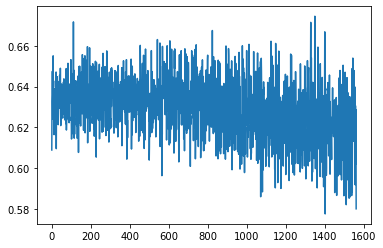

In [23]:
pd.Series(losses).plot()

## Validation

In [40]:
def validate(loader, model, top_k=[10], show_progress=True):
    model.eval()
    data = defaultdict(list)
    coverage_set = set()

    if show_progress:
        loader = track(loader)

    for batch in loader:
        users = batch[:, 0]
        items = batch[:, 1]
        with torch.no_grad():
            predictions = model(users, items)
            for k in top_k:
                hits, mrrs, dcgs = metrics(predictions, top_k=k, coverage_set=coverage_set)
                data[f"hr@{k}"].append(hits)
                data[f"mrr@{k}"].append(mrrs)
                data[f"ndcg@{k}"].append(dcgs)

    output = {}
    for metric in ["hr", "mrr", "ndcg"]:
        for k in top_k:
            name = f"{metric}@{k}"
            output[name] = np.mean(data[name])

    for k in top_k:
        name = f"cov@{k}"
        output[name] = len(coverage_set)

    return output

In [41]:
holdout = (
    data
    .drop(data_small.index)
    .pipe(reindex, data_index['items'])
    .pipe(leave_one_out, random_state=0)[1]
    .pipe(reindex, data_index['users'])
    .sort_values(data_description['users'])
)

Filtered 7512 invalid observations.
Filtered 404 invalid observations.


In [42]:
holdout.nunique()

userid       5636
movieid      1704
rating          5
timestamp    5632
dtype: int64

In [43]:
test_negative_samples = 99

In [44]:
unseen_data = sample_unseen_interactions(
    pd.concat([training, holdout], axis=0, ignore_index=True),
    np.arange(data_description['n_items']),
    n_random = test_negative_samples,
    random_state = 0,
    userid = data_description['users'],
    itemid = data_description['items']
)

In [45]:
scoring_data_ = (
    holdout
    .set_index('userid')
    ['movieid']
    .combine(unseen_data, lambda x, y: np.r_[x, y])
)

In [46]:
scoring_data_

userid
0       [121, 1176, 1192, 703, 2732, 1303, 1313, 1000,...
1       [134, 2386, 1598, 1457, 1165, 1698, 2542, 465,...
2       [2660, 37, 476, 1420, 1865, 1590, 1607, 3006, ...
3       [1776, 3000, 2993, 738, 1314, 2594, 756, 2416,...
4       [791, 1459, 675, 2213, 2248, 2257, 487, 231, 5...
                              ...                        
5631    [517, 2614, 1218, 101, 231, 994, 87, 2650, 266...
5632    [2619, 2338, 2301, 1954, 887, 2629, 1958, 2418...
5633    [930, 2955, 1519, 2766, 2163, 2654, 1350, 704,...
5634    [681, 117, 1210, 1843, 1002, 2107, 2614, 3035,...
5635    [835, 1316, 2993, 251, 2104, 1055, 487, 64, 29...
Name: movieid, Length: 5636, dtype: object

In [47]:
# check that holdout items are at the first position for each test user
assert (scoring_data_.str[0] == holdout.set_index('userid')['movieid']).all()

In [48]:
scoring_data = scoring_data_.explode().reset_index().values.astype('intp')
scoring_data

array([[   0,  121],
       [   0, 1176],
       [   0, 1192],
       ...,
       [5635,  394],
       [5635, 2883],
       [5635, 2042]], dtype=int64)

In [50]:
for batch in scoring_dl:
    break

In [51]:
batch.shape

torch.Size([100, 2])

In [52]:
for epoch in track(range(config['epochs'])):
    losses = train(train_dl, model, optimizer, criterion, show_progress=True)
    scores = validate(scoring_dl, model, top_k=[10], show_progress=True)
    cur_metrics = {'loss': np.mean(losses), **scores}
    log = f"Epoch: {epoch} | " + " | ".join(map(lambda x: f'{x[0]}: {x[1]:.3f}', cur_metrics.items()))
    print(log)

 [████████████████████████████████████████████████████████████] 2/2 [00:49<00:24, 24.35s/it]

 [████████████████████████████████████████████████████████████] 1563/1563 [00:15<00:00, 0.01s/it]

Input sequence is not exhausted.


 [████████████████████████████████████████████████████████████] 5636/5636 [00:09<00:00, 0.00s/it]

Input sequence is not exhausted.
Epoch: 0 | loss: 0.589 | hr@10: 0.406 | mrr@10: 0.144 | ndcg@10: 0.205 | cov@10: 100.000


 [████████████████████████████████████████████████████████████] 1563/1563 [00:16<00:00, 0.01s/it]

Input sequence is not exhausted.


 [████████████████████████████████████████████████████████████] 5636/5636 [00:08<00:00, 0.00s/it]

Input sequence is not exhausted.
Epoch: 1 | loss: 0.576 | hr@10: 0.416 | mrr@10: 0.149 | ndcg@10: 0.211 | cov@10: 100.000
